In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, make_scorer, accuracy_score, precision_score, classification_report, f1_score, roc_auc_score, average_precision_score, fbeta_score, log_loss
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials, STATUS_FAIL
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm
import xgboost
import shap

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hr-analytics-dataset/HR_Analytics.csv


In [2]:
data = pd.read_csv('/kaggle/input/hr-analytics-dataset/HR_Analytics.csv')
with pd.option_context('display.max_columns', None):
    display(data.head())

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,SalarySlab,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,1,405,3,Male,54,3,1,Laboratory Technician,3,Single,1420,Upto 5k,25233,1,Y,No,13,3,3,80,0,0,2,3,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,1,411,4,Female,69,2,1,Sales Representative,3,Single,1200,Upto 5k,9724,1,Y,No,12,3,1,80,0,0,2,3,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,1,614,2,Male,69,3,1,Sales Representative,2,Single,1878,Upto 5k,8059,1,Y,Yes,14,3,4,80,0,0,3,3,0,0,0,0.0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,1,1012,2,Male,73,3,1,Research Scientist,4,Single,1051,Upto 5k,13493,1,Y,No,15,3,4,80,0,0,2,3,0,0,0,0.0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,1,1156,3,Male,80,3,1,Laboratory Technician,3,Single,1904,Upto 5k,13556,1,Y,No,12,3,4,80,0,0,0,3,0,0,0,0.0


In [3]:
summ = data.groupby('Attrition').agg(count = pd.NamedAgg(column = 'EmpID', aggfunc = 'count'))
summ['perc_total'] = summ['count']/summ['count'].sum()
summ

,count,perc_total
Attrition,,
No,1242,0.839189
Yes,238,0.160811


In [4]:
with pd.option_context('display.max_columns', None):
    display(data.describe())

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1423.000000
mean,36.917568,801.384459,9.220270,2.910811,1.0,1031.860811,2.724324,65.845270,2.729730,2.064865,2.725000,6504.985811,14298.460811,2.687162,15.210135,3.153378,2.708784,80.0,0.791892,11.281757,2.797973,2.760811,7.009459,4.228378,2.182432,4.118060
std,9.128559,403.126988,8.131201,1.023796,0.0,605.955046,1.092579,20.328266,0.713007,1.105574,1.104137,4700.261400,7112.056802,2.494098,3.655338,0.360474,1.081995,0.0,0.850527,7.770870,1.288791,0.707024,6.117945,3.616020,3.219357,3.555484
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,493.750000,2.000000,48.000000,2.000000,1.000000,2.000000,2922.250000,8051.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,800.000000,7.000000,3.000000,1.0,1027.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4933.000000,14220.000000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1568.250000,4.000000,83.000000,3.000000,3.000000,4.000000,8383.750000,20460.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [5]:
class FeatureSelector:
    def check_cols_nulls(df):
        null = df.isna().sum()
        null = null[null>0]
        for col in null.index:
            print(f"{col}: {100*null[col]/len(df): 0.2f}% null")
        return list(null.index)
    
    def get_num_cols(df):
        dtypes = df.dtypes.to_dict()
        num_cols = []
        for col, dtype in dtypes.items():
            if dtype in ['float', 'int']:
                num_cols.append(col)
        return num_cols
    
    def get_cat_cols(df, max_cat = 50):
        max_cat = min(max_cat, len(df) * 0.2)
        dtypes = df.dtypes.to_dict()
        cat_cols = []
        for col, dtype in dtypes.items():
            if dtype == 'object' and df[col].nunique() < max_cat:
                cat_cols.append(col)
        return cat_cols        
        
    def labelencode(df, column, mapping = None):
        colname = f'LE_{column}'
        if colname in df.columns:
            df = df.drop([colname], axis = 1)
        if not mapping:
            mapping = {}
            for i, k in enumerate(df[column].unique()):
                mapping[k] = i + 1
        df[colname] = df[column].map(mapping)
        return df
    
    def onehotencode(df, column, value_map = None, prefix = None):
        if prefix is None:
            prefix = column
        if value_map:
            df[column] = df[column].map(value_map)
        concat = pd.get_dummies(df[column], prefix = prefix)
        df = pd.concat([df, concat], axis = 1)
        return df
    
    def drop_no_var(df):
        for col in df.columns:
            if df[col].nunique() <= 1:
                df = df.drop([col], axis = 1)
                print(f"Dropped Column {col}: No Variance")
        return df
    
    def bool_to_int(df, columns = None):
        if not columns:
            columns = df.columns
        dtypes = df.dtypes.to_dict()
        for col, dtype in dtypes.items():
            if dtype == 'bool' and col in columns:
                df[col] = df[col].astype(int)
        return df
    
    def get_high_corr_vars(df, threshold = 0.9):
        num_cols = FeatureSelector.get_num_cols(df)
        corr_mat = df[num_cols].corr()
        mask = np.triu(np.ones_like(corr_mat, dtype=bool), k=0)
        corr_mat = corr_mat.where(~mask)
        for col in corr_mat:
            for ind in corr_mat[corr_mat[col] >= threshold].index:
                print(f"{col} - {ind}: {corr_mat.loc[ind, col]:0.2f}")
    
class Models:
    import warnings
    warnings.filterwarnings('ignore')
    
    def fbeta(precision, recall, beta = 1):
        return (1 + beta ** 2) * (precision * recall)/(beta ** 2 * precision + recall)
    
    def classification_metrics(y_true, y_proba, thresh_perc = 80):
        threshold = np.percentile(y_proba, thresh_perc)
        y_pred = (y_proba >= threshold).astype(int)
        
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'f2': fbeta_score(y_true, y_pred, beta = 2),
            'roc_auc': roc_auc_score(y_true, y_proba),
            'pr_auc': average_precision_score(y_true, y_proba)
        }
    
        return metrics
    
    def cross_validation(model, X, y, folds=5):
        kf = KFold(n_splits=folds, shuffle=True)
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'f2': [],
            'roc_auc': [],
            'pr_auc': []
        }
        for train_index, test_index in kf.split(X):
            X_trainf, X_testf = X.iloc[train_index], X.iloc[test_index]
            y_trainf, y_testf = y.iloc[train_index], y.iloc[test_index]

            # Clone the model to avoid fitting it on the same data
            model_clone = clone(model)
            model_clone.fit(X_trainf, y_trainf)

            y_proba = model_clone.predict_proba(X_testf)[:,1]
            
            results = Models.classification_metrics(y_testf, y_proba)
            
            # Calculate metrics
            metrics['accuracy'].append(results['accuracy'])
            metrics['precision'].append(results['precision'])
            metrics['recall'].append(results['recall'])
            metrics['f1'].append(results['f1'])
            metrics['f2'].append(results['f2'])
            metrics['roc_auc'].append(results['roc_auc'])
            metrics['pr_auc'].append(results['pr_auc'])

        avg_metrics = {key: np.mean(value) for key, value in metrics.items()}
        return avg_metrics
    
    def optimize_model(space, model, X, y, max_trials = 200, verbose = 1):
        
        trial_results = []
        def objective(params):
            
            for name, k in params.items():
                if isinstance(k, (int, float)) and int(k) == k:
                    params[name] = int(k)
            
            
            model_copy = clone(model)
            model_copy.set_params(**params)
            
            try:
                metrics = Models.cross_validation(model_copy, X, y)
                
                if verbose > 0:
                    print(params)
                    print(f"{params}: {metrics}")
                    
                loss = ((metrics['precision']) * (metrics['precision']>0.2)) * (metrics['recall']) * (metrics['recall'] > 0.4)

                result = {
                    'loss': -loss,  
                    'status': STATUS_OK,
                    'metrics': metrics
                }
        
            except Exception as e:
                if verbose > 0:
                    print(f"Invalid Parameter")
                metrics = {
                    'accuracy': np.nan,
                    'precision': np.nan,
                    'recall': np.nan,
                    'f1': np.nan,
                    'f2': np.nan,
                    'roc_auc': np.nan,
                    'pr_auc': np.nan
                }

                loss = np.nan
                
                result = {'loss': loss, 'status': STATUS_FAIL, 'metrics': metrics}

            #results_df = pd.read_csv(filesave)
            #results_df.loc[len(results_df)] = [len(results_df), result['loss'], result['status']] + list(metrics.values())
            #results_df.to_csv(filesave, index = None)
            trial_results.append({'params': params, 'loss': -loss, 'metrics': metrics})
            return result

        
        trials = Trials()
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_trials,
            trials=trials
        )

        df_results = pd.DataFrame(trial_results)
        df_results = df_results.dropna()
        df_results = df_results[~df_results['metrics'].isna()]
        df_metrics = df_results['metrics'].apply(pd.Series)

        df_results = pd.concat([df_results.drop(columns=['metrics']), df_metrics], axis=1)
        
        return df_results.sort_values(by = 'loss')

##### Among all the columns, only 'YearsWithCurrManager' has null values. We will impute this with the mean.

In [6]:
FeatureSelector.check_cols_nulls(data)
data['YearsWithCurrManager'] = data['YearsWithCurrManager'].fillna(data['YearsWithCurrManager'].mean())

YearsWithCurrManager:  3.85% null


In [7]:
data = FeatureSelector.drop_no_var(data)

Dropped Column EmployeeCount: No Variance
Dropped Column Over18: No Variance
Dropped Column StandardHours: No Variance


In [8]:
cat_cols = FeatureSelector.get_cat_cols(data)
cat_cols

['AgeGroup',
 'Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'SalarySlab',
 'OverTime']

In [9]:
data = FeatureSelector.labelencode(data, 'AgeGroup', {'18-25':1, '26-35':2, '36-45':3, '46-55':4, '55+':5})
data['AgeGroup'].value_counts()

AgeGroup
26-35    611
36-45    471
46-55    228
18-25    123
55+       47
Name: count, dtype: int64

In [10]:
data = FeatureSelector.labelencode(data, 'Attrition', {'Yes': 1, 'No': 0})
data = data.rename(columns = {'LE_Attrition': 'target'})
data['Attrition'].value_counts()

Attrition
No     1242
Yes     238
Name: count, dtype: int64

In [11]:
data

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,LE_AgeGroup,target
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,0,0,2,3,0,0,0,0.0,1,1
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,0,0,2,3,0,0,0,0.0,1,0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,0,0,3,3,0,0,0,0.0,1,1
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,0,0,2,3,0,0,0,0.0,1,0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,0,0,0,3,0,0,0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,RM412,60,55+,No,Travel_Rarely,422,Research & Development,7,3,Life Sciences,...,0,33,5,1,29,8,11,10.0,5,0
1476,RM428,60,55+,No,Travel_Frequently,1499,Sales,28,3,Marketing,...,0,22,5,4,18,13,13,11.0,5,0
1477,RM537,60,55+,No,Travel_Rarely,1179,Sales,16,4,Marketing,...,0,10,1,3,2,2,2,2.0,5,0
1478,RM880,60,55+,No,Travel_Rarely,696,Sales,7,4,Marketing,...,1,12,3,3,11,7,1,9.0,5,0


In [12]:
data['BusinessTravel'] = np.where(data['BusinessTravel'] == 'TravelRarely', 'Travel_Rarely', data['BusinessTravel']) 
FeatureSelector.labelencode(data, 'AgeGroup', {'Non-Travel':1, 'Travel_Rarely':2, 'Travel_Frequently': 3})
data['BusinessTravel'].value_counts()

BusinessTravel
Travel_Rarely        1050
Travel_Frequently     279
Non-Travel            151
Name: count, dtype: int64

In [13]:
data = FeatureSelector.onehotencode(data, 'Department', value_map = {'Research & Development': 'RD', 'Sales': 'Sales', 'Human Resources': 'HR'}, prefix = 'Dept')
data['Department'].value_counts()

Department
RD       967
Sales    450
HR        63
Name: count, dtype: int64

In [14]:
data = FeatureSelector.onehotencode(data, 'EducationField', value_map = {'Life Sciences': 'LifSci', 'Medical': 'Med', 'Marketing': 'Mktg',
                                                                        'Technical Degree': 'Tech', 'Human Resources': 'HR', 'Other': 'Other'}, prefix = 'Degree')
data['EducationField'].value_counts()

EducationField
LifSci    607
Med       470
Mktg      161
Tech      132
Other      83
HR         27
Name: count, dtype: int64

In [15]:
data = FeatureSelector.labelencode(data, 'Gender', mapping = {'Male': 1, 'Female': '0'})
data = data.rename(columns = {'LE_Gender': 'Male'})
data['Gender'].value_counts()

Gender
Male      889
Female    591
Name: count, dtype: int64

In [16]:
data = FeatureSelector.onehotencode(data, 'JobRole', prefix = 'Role')
data['JobRole'].value_counts()

JobRole
Sales Executive              329
Research Scientist           293
Laboratory Technician        261
Manufacturing Director       147
Healthcare Representative    132
Manager                      102
Sales Representative          84
Research Director             80
Human Resources               52
Name: count, dtype: int64

In [17]:
data  = FeatureSelector.onehotencode(data, 'MaritalStatus', prefix = '')
data['MaritalStatus'].value_counts()

MaritalStatus
Married     679
Single      473
Divorced    328
Name: count, dtype: int64

In [18]:
data = FeatureSelector.labelencode(data, 'SalarySlab', {'Upto 5k': 1, '5k-10k': 2, '10k-15k': 3, '15k+': 4})
data['SalarySlab'].value_counts()

SalarySlab
Upto 5k    753
5k-10k     444
10k-15k    150
15k+       133
Name: count, dtype: int64

In [19]:
data = FeatureSelector.labelencode(data, 'OverTime', {'Yes': 1, 'No': 0})
data['OverTime'].value_counts()

OverTime
No     1062
Yes     418
Name: count, dtype: int64

In [20]:
data = FeatureSelector.bool_to_int(data)
data

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,Role_Manufacturing Director,Role_Research Director,Role_Research Scientist,Role_Sales Executive,Role_Sales Representative,_Divorced,_Married,_Single,LE_SalarySlab,LE_OverTime
0,RM297,18,18-25,Yes,Travel_Rarely,230,RD,3,3,LifSci,...,0,0,0,0,0,0,0,1,1,0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Med,...,0,0,0,0,1,0,0,1,1,0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Mktg,...,0,0,0,0,1,0,0,1,1,1
3,RM728,18,18-25,No,Non-Travel,287,RD,5,2,LifSci,...,0,0,1,0,0,0,0,1,1,0
4,RM829,18,18-25,Yes,Non-Travel,247,RD,8,1,Med,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,RM412,60,55+,No,Travel_Rarely,422,RD,7,3,LifSci,...,0,0,0,0,0,0,1,0,4,0
1476,RM428,60,55+,No,Travel_Frequently,1499,Sales,28,3,Mktg,...,0,0,0,1,0,0,1,0,3,0
1477,RM537,60,55+,No,Travel_Rarely,1179,Sales,16,4,Mktg,...,0,0,0,1,0,0,0,1,2,0
1478,RM880,60,55+,No,Travel_Rarely,696,Sales,7,4,Mktg,...,0,0,0,1,0,1,0,0,2,1


In [21]:
num_cols = FeatureSelector.get_num_cols(data)
len(num_cols)

49

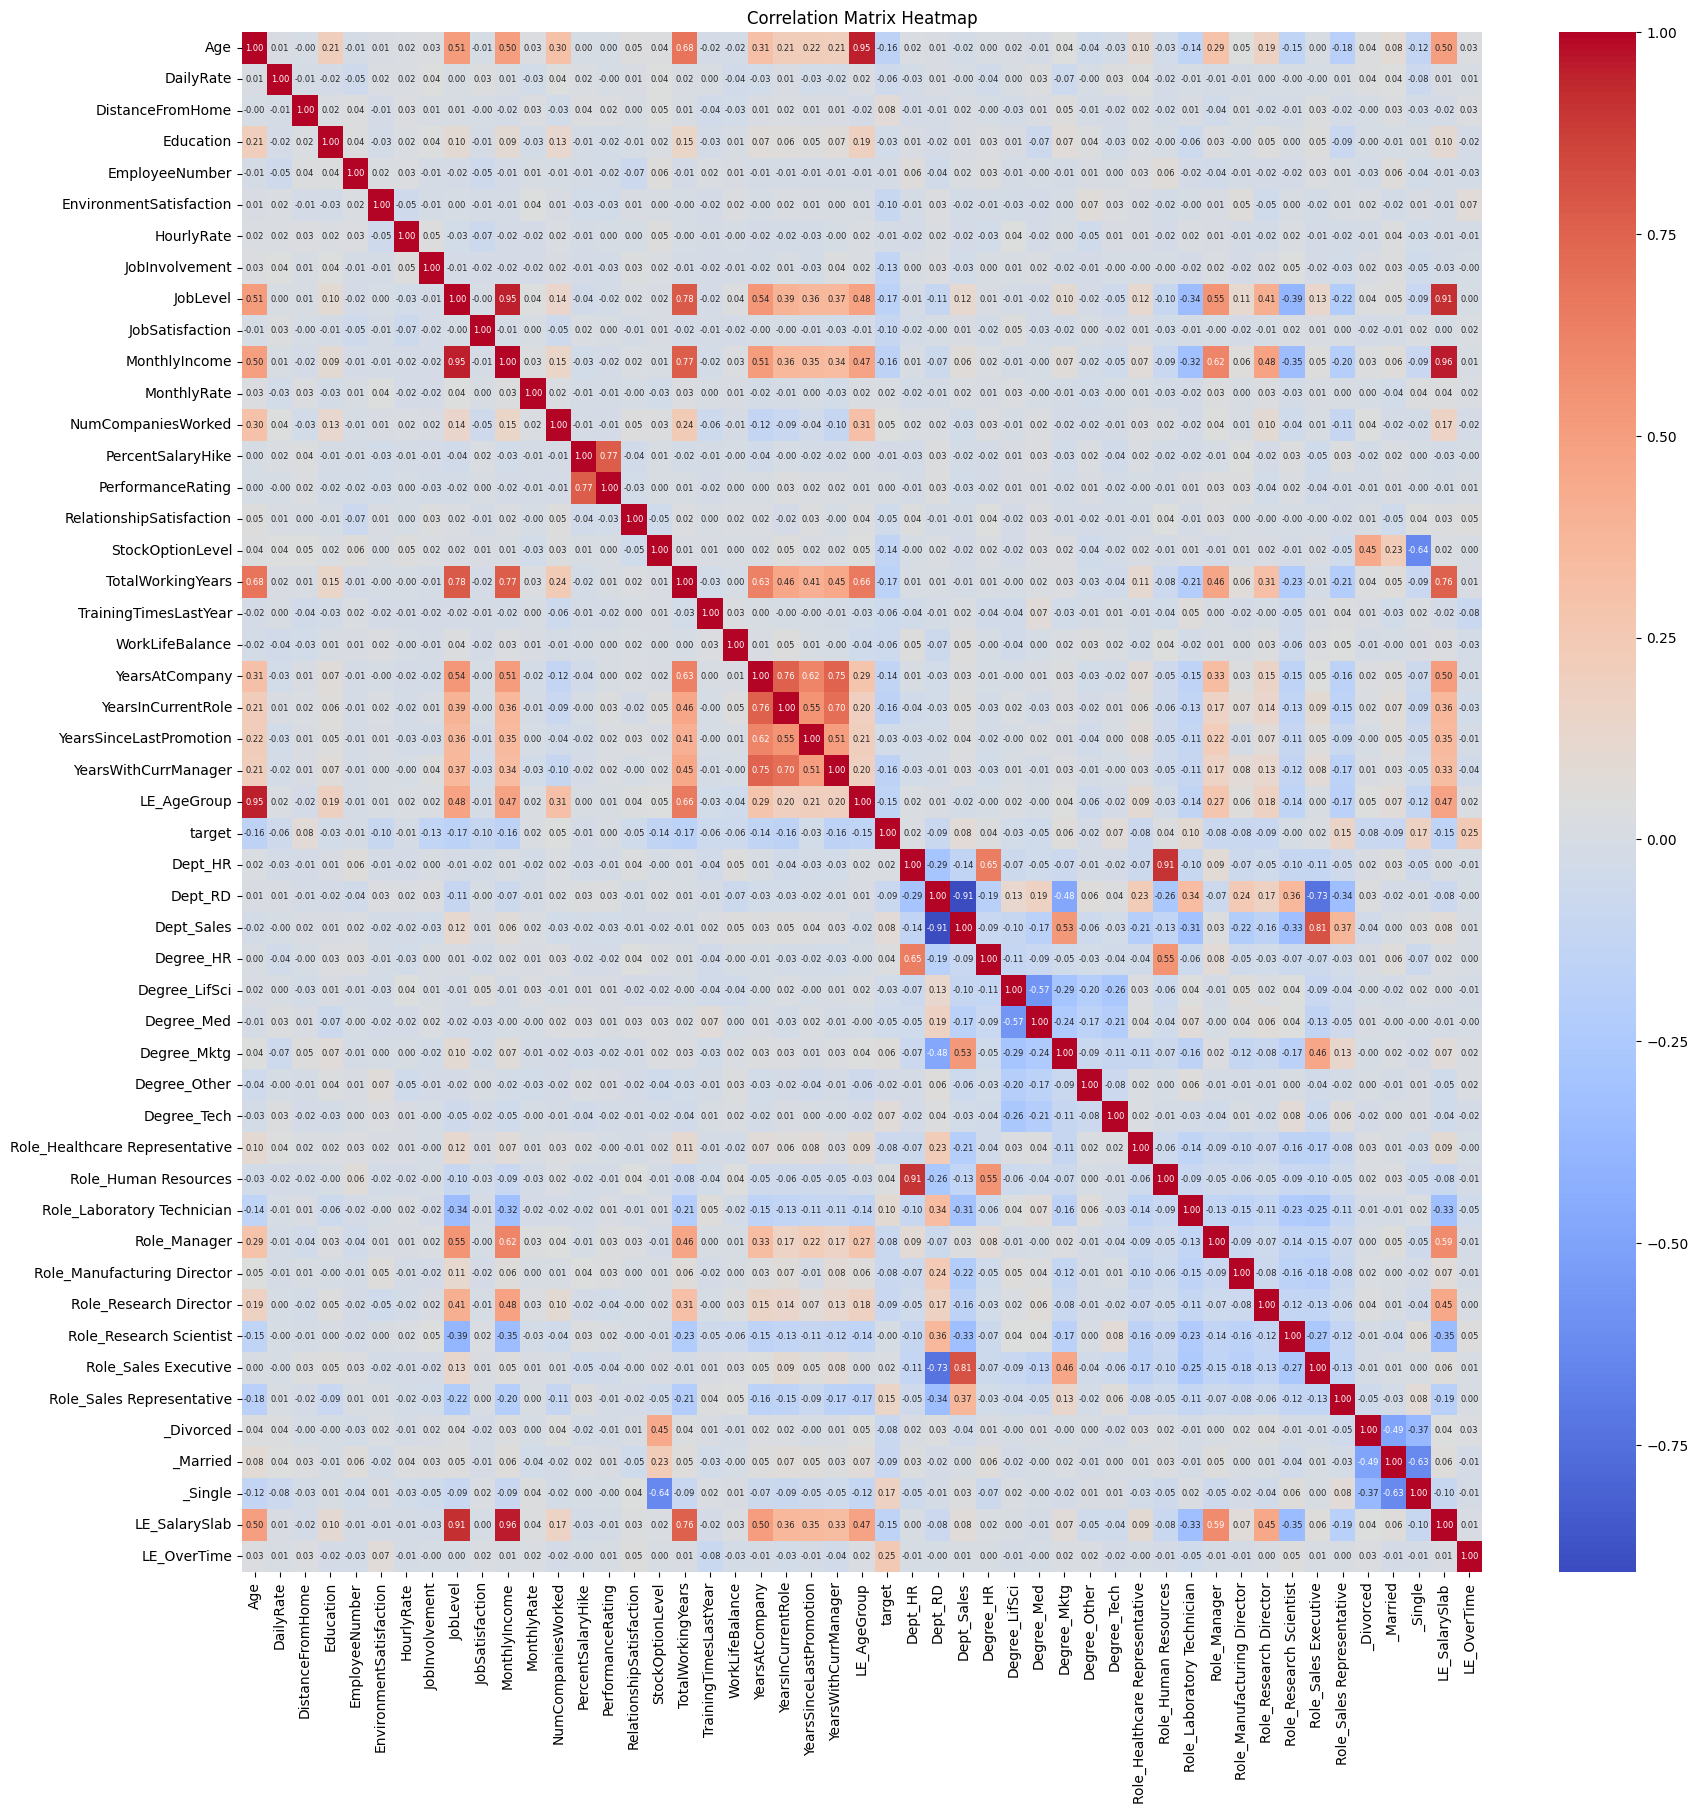

In [22]:
corr_mat = data[num_cols].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

plt.title('Correlation Matrix Heatmap')
plt.show()

In [23]:
FeatureSelector.get_high_corr_vars(data)

Age - LE_AgeGroup: 0.95
JobLevel - MonthlyIncome: 0.95
JobLevel - LE_SalarySlab: 0.91
MonthlyIncome - LE_SalarySlab: 0.96
Dept_HR - Role_Human Resources: 0.91


In [24]:
feature_cols = [col for col in num_cols if col not in ['LE_AgeGroup', 'LE_SalarySlab', 'target']]
X = data[feature_cols]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [25]:
logreg_space = {
    'C': hp.loguniform('C', np.log(1e-4), np.log(1e4)),  # Log-uniform distribution for regularization strength
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', 'none']),  # Regularization type
    'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'saga']),  # Optimization algorithm
    'max_iter': hp.quniform('max_iter', 100, 1000, 10),  # Integer number of iterations
    'class_weight': hp.choice('class_weight', [None, 'balanced']),  # Handling class imbalance
    'tol': hp.loguniform('tol', np.log(1e-6), np.log(1e-3))  # Tolerance for stopping criteria
}
model = LogisticRegression(random_state = 42)
lr_results = Models.optimize_model(logreg_space, model, X_train, y_train, 500, -1)

100%|██████████| 500/500 [02:42<00:00,  3.08trial/s, best loss: -0.30042142120005905]


In [26]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(lr_results)

,params,loss,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
298,"{'C': 0.0007187659373546415, 'class_weight': None, 'max_iter': 630, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 1.2382586275205403e-06}",-0.300421,0.833627,0.487500,0.616249,0.543068,0.584317,0.821931,0.608327
17,"{'C': 0.5579223119469127, 'class_weight': None, 'max_iter': 690, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0002021560115195985}",-0.293842,0.831914,0.483333,0.607949,0.533383,0.573687,0.810404,0.598756
442,"{'C': 0.0580257406789288, 'class_weight': None, 'max_iter': 700, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.0003803665178448835}",-0.289789,0.830251,0.479167,0.604777,0.534039,0.574124,0.822059,0.609695
25,"{'C': 0.0002852135464519175, 'class_weight': None, 'max_iter': 880, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 1.0868798732099134e-05}",-0.285379,0.828531,0.475000,0.600797,0.528552,0.568943,0.807653,0.584802
34,"{'C': 15.338958620715701, 'class_weight': 'balanced', 'max_iter': 770, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 5.842223741774396e-06}",-0.284502,0.826890,0.470833,0.604253,0.521295,0.565614,0.813377,0.567048
155,"{'C': 0.05752697056513922, 'class_weight': None, 'max_iter': 870, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.0008246887279567477}",-0.283275,0.828542,0.475000,0.596369,0.528239,0.566932,0.807682,0.598806
474,"{'C': 9.15368761366929, 'class_weight': None, 'max_iter': 620, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 1.0987202169695125e-06}",-0.278907,0.826861,0.470833,0.592368,0.524355,0.563048,0.814796,0.592801
215,"{'C': 0.00013492395012469093, 'class_weight': None, 'max_iter': 840, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.0002685340201214856}",-0.273980,0.825170,0.466667,0.587101,0.517803,0.556544,0.797587,0.584299
14,"{'C': 1509.4262606585687, 'class_weight': 'balanced', 'max_iter': 160, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 7.682786202993336e-05}",-0.269334,0.823479,0.462500,0.582343,0.514102,0.552487,0.799051,0.548196
37,"{'C': 0.1816484454187038, 'class_weight': None, 'max_iter': 690, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 6.228831628965133e-06}",-0.268355,0.823489,0.462500,0.580227,0.513436,0.551122,0.811487,0.587359


In [27]:
lr = LogisticRegression(**lr_results.iloc[0]['params']).fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)[:,1]
lr_test = Models.classification_metrics(y_test, lr_proba)
lr_test

{'accuracy': 0.8209459459459459,
 'precision': 0.45,
 'recall': 0.574468085106383,
 'f1': 0.5046728971962617,
 'f2': 0.5443548387096774,
 'roc_auc': 0.849696658976331,
 'pr_auc': 0.5869755452951738}

In [1]:
X.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,Role_Manager,Role_Manufacturing Director,Role_Research Director,Role_Research Scientist,Role_Sales Executive,Role_Sales Representative,_Divorced,_Married,_Single,LE_OverTime
0,18,230,3,3,405,3,54,3,1,3,...,0,0,0,0,0,0,0,0,1,0
1,18,812,10,3,411,4,69,2,1,3,...,0,0,0,0,0,1,0,0,1,0
2,18,1306,5,3,614,2,69,3,1,2,...,0,0,0,0,0,1,0,0,1,1
3,18,287,5,2,1012,2,73,3,1,4,...,0,0,0,1,0,0,0,0,1,0
4,18,247,8,1,1156,3,80,3,1,3,...,0,0,0,0,0,0,0,0,1,0


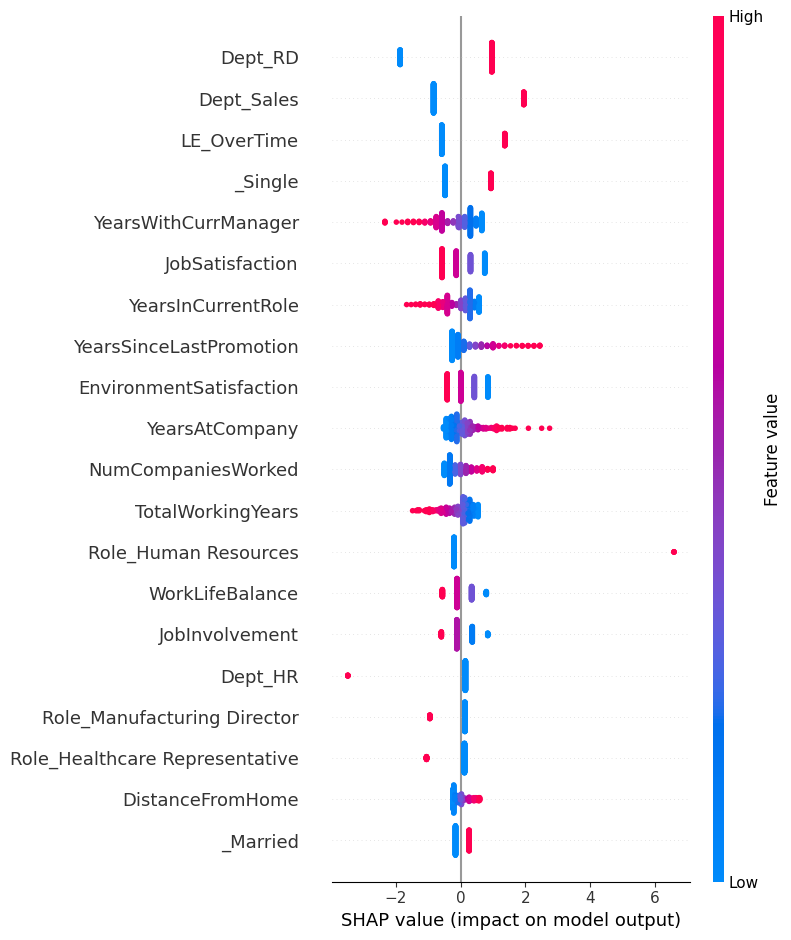

In [28]:
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

#### K-Nearest Neighbors Classification

In [29]:
knn_space = {
    'n_neighbors': hp.randint('n_neighbors', 50) + 1,  # Range: 1 to 50
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
    'p': hp.choice('p', [1, 2]),
    'leaf_size': hp.randint('leaf_size', 40) + 10  # Range: 10 to 50
}
model = KNeighborsClassifier()
knn_results = Models.optimize_model(knn_space, model, X_train, y_train, 500, -1)

100%|██████████| 500/500 [00:17<00:00, 28.61trial/s, best loss: -0.10795003362971431]


In [30]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(knn_results)

,params,loss,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
39,"{'algorithm': 'kd_tree', 'leaf_size': 29, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",-0.107950,0.679025,0.239868,0.450039,0.308803,0.377479,0.605561,0.227676
31,"{'algorithm': 'kd_tree', 'leaf_size': 31, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",-0.103691,0.677358,0.235854,0.439640,0.303059,0.369742,0.593509,0.215964
30,"{'algorithm': 'kd_tree', 'leaf_size': 26, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",-0.101797,0.680702,0.234157,0.434737,0.302811,0.369363,0.596344,0.219887
309,"{'algorithm': 'kd_tree', 'leaf_size': 46, 'n_neighbors': 24, 'p': 1, 'weights': 'uniform'}",-0.100257,0.706973,0.247689,0.404771,0.306793,0.358678,0.629619,0.248753
27,"{'algorithm': 'kd_tree', 'leaf_size': 23, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",-0.096484,0.660473,0.221931,0.434746,0.290411,0.360452,0.594870,0.210064
29,"{'algorithm': 'kd_tree', 'leaf_size': 26, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",-0.090705,0.672324,0.219913,0.412459,0.284795,0.348470,0.600291,0.218237
0,"{'algorithm': 'ball_tree', 'leaf_size': 23, 'n_neighbors': 23, 'p': 2, 'weights': 'uniform'}",-0.000000,0.711117,0.219140,0.304641,0.252784,0.280729,0.601785,0.240476
4,"{'algorithm': 'kd_tree', 'leaf_size': 42, 'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}",-0.000000,0.707759,0.241168,0.375657,0.290573,0.334919,0.616348,0.236628
13,"{'algorithm': 'kd_tree', 'leaf_size': 21, 'n_neighbors': 23, 'p': 2, 'weights': 'uniform'}",-0.000000,0.707759,0.236942,0.366808,0.285786,0.328490,0.613382,0.227788
14,"{'algorithm': 'auto', 'leaf_size': 43, 'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}",-0.000000,0.172309,0.161264,0.982120,0.276586,0.485071,0.497276,0.161658


In [31]:
knn = KNeighborsClassifier(**knn_results.iloc[0]['params']).fit(X_train, y_train)
knn_proba = knn.predict_proba(X_test)[:,1]
knn_test = Models.classification_metrics(y_test, knn_proba)
knn_test

{'accuracy': 0.6756756756756757,
 'precision': 0.23076923076923078,
 'recall': 0.44680851063829785,
 'f1': 0.30434782608695654,
 'f2': 0.3763440860215053,
 'roc_auc': 0.6152268649064343,
 'pr_auc': 0.24457052006575117}

#### RandomForest Classifier

In [32]:
rf_space = {
    'n_estimators': hp.randint('n_estimators', 2, 201),  # Number of trees in the forest
    'max_depth': hp.choice('max_depth', list(range(3, 51))),  # Max depth of the tree
    'min_samples_split': hp.randint('min_samples_split', 2, 500),  # Minimum number of samples to split
    'min_samples_leaf': hp.randint('min_samples_leaf', 2, 500),  # Minimum number of samples at a leaf node
    'max_features': hp.quniform('max_features', 0.01, 1, 0.01),  # Number of features to consider at each split
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
    'bootstrap': hp.choice('bootstrap', [True, False]),  # Whether to use bootstrap samples
}
model = RandomForestClassifier(random_state = 42)
rf_results = Models.optimize_model(rf_space, model, X_train, y_train, 500, -1)

100%|██████████| 500/500 [11:23<00:00,  1.37s/trial, best loss: -0.2765575404487006]


In [33]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(rf_results)

,params,loss,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
285,"{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 0.47000000000000003, 'min_samples_leaf': 3, 'min_samples_split': 98, 'n_estimators': 157}",-0.276558,0.826865,0.470833,0.587379,0.518797,0.556547,0.777737,0.509186
328,"{'bootstrap': 1, 'criterion': 'log_loss', 'max_depth': 45, 'max_features': 0.32, 'min_samples_leaf': 34, 'min_samples_split': 160, 'n_estimators': 110}",-0.276081,0.823443,0.462500,0.596932,0.517047,0.560598,0.782096,0.518314
140,"{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 45, 'max_features': 0.79, 'min_samples_leaf': 22, 'min_samples_split': 44, 'n_estimators': 162}",-0.275549,0.826861,0.470833,0.585236,0.519888,0.556528,0.786062,0.519110
175,"{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 48, 'max_features': 0.7000000000000001, 'min_samples_leaf': 21, 'min_samples_split': 72, 'n_estimators': 149}",-0.269139,0.823475,0.462500,0.581922,0.513699,0.552058,0.789339,0.523514
4,"{'bootstrap': 1, 'criterion': 'log_loss', 'max_depth': 48, 'max_features': 0.47000000000000003, 'min_samples_leaf': 95, 'min_samples_split': 351, 'n_estimators': 110}",-0.264980,0.821766,0.458333,0.578139,0.510884,0.549075,0.767471,0.504797
...,...,...,...,...,...,...,...,...,...
497,"{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 0.19, 'min_samples_leaf': 428, 'min_samples_split': 212, 'n_estimators': 7}",-0.000000,0.161339,0.161339,1.000000,0.277129,0.487694,0.500000,0.161339
483,"{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 0.66, 'min_samples_leaf': 379, 'min_samples_split': 286, 'n_estimators': 160}",-0.000000,0.161310,0.161310,1.000000,0.277087,0.487741,0.500000,0.161310
499,"{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 45, 'max_features': 0.45, 'min_samples_leaf': 409, 'min_samples_split': 324, 'n_estimators': 196}",-0.000000,0.161335,0.161335,1.000000,0.277236,0.488103,0.500000,0.161335
0,"{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 0.81, 'min_samples_leaf': 481, 'min_samples_split': 136, 'n_estimators': 102}",-0.000000,0.161328,0.161328,1.000000,0.277734,0.489915,0.500000,0.161328


In [34]:
rf = RandomForestClassifier(**rf_results.iloc[0]['params']).fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)[:,1]
rf_test = Models.classification_metrics(y_test, rf_proba)
rf_test

{'accuracy': 0.8006756756756757,
 'precision': 0.4,
 'recall': 0.5106382978723404,
 'f1': 0.4485981308411215,
 'f2': 0.48387096774193544,
 'roc_auc': 0.8072289156626505,
 'pr_auc': 0.5011451531123486}

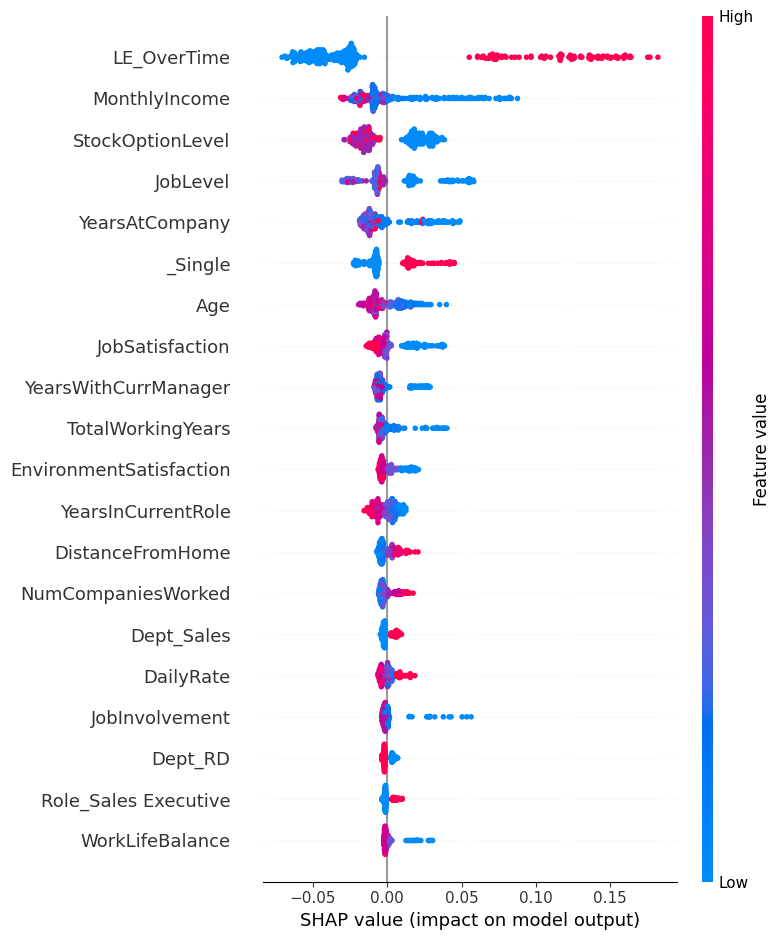

In [35]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values[:,:,1].values, X_test)

#### LightGBM

In [36]:
lgbm_space = {
    'max_depth': hp.quniform("max_depth", 3, 10, 1),  #Max depth 10
    'gamma': hp.loguniform('gamma', np.log(1), np.log(100)),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.loguniform('min_child_weight',np.log(1), np.log(100)),
    'n_estimators': hp.quniform('n_estimators', 50, 250, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'random_state': 42,   
    'verbose': -1
}
model = lightgbm.LGBMClassifier()
lgbm_results = Models.optimize_model(lgbm_space, model, X_train, y_train, 500, -1)

100%|██████████| 500/500 [03:28<00:00,  2.40trial/s, best loss: -0.330171398046398]  


In [37]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(lgbm_results)

,params,loss,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
478,"{'colsample_bytree': 0.8699185088144086, 'gamma': 18.432533631421812, 'learning_rate': 0.07307123541170998, 'max_depth': 9, 'min_child_weight': 4.482534881021637, 'n_estimators': 225, 'random_state': 42, 'reg_alpha': 6.598284713028451, 'reg_lambda': 6.263566830171502, 'subsample': 0.591584055558517, 'verbose': -1}",-0.330171,0.843746,0.512500,0.644237,0.570291,0.612281,0.818848,0.569427
425,"{'colsample_bytree': 0.7609212627753775, 'gamma': 39.940725620887655, 'learning_rate': 0.09039244477546718, 'max_depth': 8, 'min_child_weight': 12.564190566855656, 'n_estimators': 209, 'random_state': 42, 'reg_alpha': 5.996218997249929, 'reg_lambda': 2.7556379903314236, 'subsample': 0.6581830844253264, 'verbose': -1}",-0.328519,0.843764,0.512500,0.641013,0.566280,0.607788,0.826273,0.590414
312,"{'colsample_bytree': 0.7062058087613059, 'gamma': 30.297927922183735, 'learning_rate': 0.040583955587818965, 'max_depth': 8, 'min_child_weight': 11.191756056647927, 'n_estimators': 242, 'random_state': 42, 'reg_alpha': 3.8839599004917016, 'reg_lambda': 0.651755042140584, 'subsample': 0.8950717213783763, 'verbose': -1}",-0.324811,0.842065,0.508333,0.638973,0.565850,0.607448,0.820592,0.580758
439,"{'colsample_bytree': 0.8519325996241344, 'gamma': 42.248656478366094, 'learning_rate': 0.1839894331217508, 'max_depth': 8, 'min_child_weight': 21.98544662196826, 'n_estimators': 163, 'random_state': 42, 'reg_alpha': 5.903518148542608, 'reg_lambda': 2.265991401107474, 'subsample': 0.6799778889297219, 'verbose': -1}",-0.324750,0.842040,0.508333,0.638852,0.565880,0.607417,0.809301,0.596575
239,"{'colsample_bytree': 0.6738158031530069, 'gamma': 38.33818942811043, 'learning_rate': 0.16877661473197172, 'max_depth': 8, 'min_child_weight': 14.090618789775467, 'n_estimators': 182, 'random_state': 42, 'reg_alpha': 7.431907169925469, 'reg_lambda': 4.119447017712558, 'subsample': 0.7218991257364725, 'verbose': -1}",-0.322298,0.840385,0.504167,0.639268,0.560824,0.604379,0.805303,0.565198
...,...,...,...,...,...,...,...,...,...
171,"{'colsample_bytree': 0.6838246766546805, 'gamma': 25.012245945654218, 'learning_rate': 0.037570846444299665, 'max_depth': 9, 'min_child_weight': 83.14342208583906, 'n_estimators': 107, 'random_state': 42, 'reg_alpha': 2.647700701497282, 'reg_lambda': 7.178848244558558, 'subsample': 0.6253158389277211, 'verbose': -1}",-0.000000,0.161324,0.161324,1.000000,0.277266,0.488270,0.500000,0.161324
225,"{'colsample_bytree': 0.5243195101797599, 'gamma': 6.9168270492576776, 'learning_rate': 0.08958249219575949, 'max_depth': 10, 'min_child_weight': 80.07003071634887, 'n_estimators': 119, 'random_state': 42, 'reg_alpha': 2.2878970388628836, 'reg_lambda': 8.06491466814418, 'subsample': 0.5699408281691349, 'verbose': -1}",-0.000000,0.161324,0.161324,1.000000,0.277470,0.489019,0.500000,0.161324
63,"{'colsample_bytree': 0.8693563623155955, 'gamma': 45.11089350173662, 'learning_rate': 0.06542564210932902, 'max_depth': 7, 'min_child_weight': 82.82513304398387, 'n_estimators': 131, 'random_state': 42, 'reg_alpha': 1.8680728331610004, 'reg_lambda': 2.574717900385776, 'subsample': 0.73146628881891, 'verbose': -1}",-0.000000,0.161310,0.161310,1.000000,0.277186,0.488026,0.500000,0.161310
9,"{'colsample_bytree': 0.8870476439112376, 'gamma': 35.01411618705852, 'learning_rate': 0.0329430050142903, 'max_depth': 5, 'min_child_weight': 99.67370619205826, 'n_estimators': 110, 'random_state': 42, 'reg_alpha': 2.5237180278943794, 'reg_lambda': 5.561341484479765, 'subsample': 0.6546975986014751, 'verbose': -1}",-0.000000,0.161335,0.161335,1.000000,0.277404,0.488722,0.500000,0.161335


In [38]:
lgbm = lightgbm.LGBMClassifier(**lgbm_results.iloc[0]['params']).fit(X_train, y_train)
lgbm_proba = lgbm.predict_proba(X_test)[:,1]
lgbm_test = Models.classification_metrics(y_test, lgbm_proba)
lgbm_test

{'accuracy': 0.8344594594594594,
 'precision': 0.48333333333333334,
 'recall': 0.6170212765957447,
 'f1': 0.5420560747663552,
 'f2': 0.5846774193548387,
 'roc_auc': 0.8297017858668717,
 'pr_auc': 0.5568856420261336}

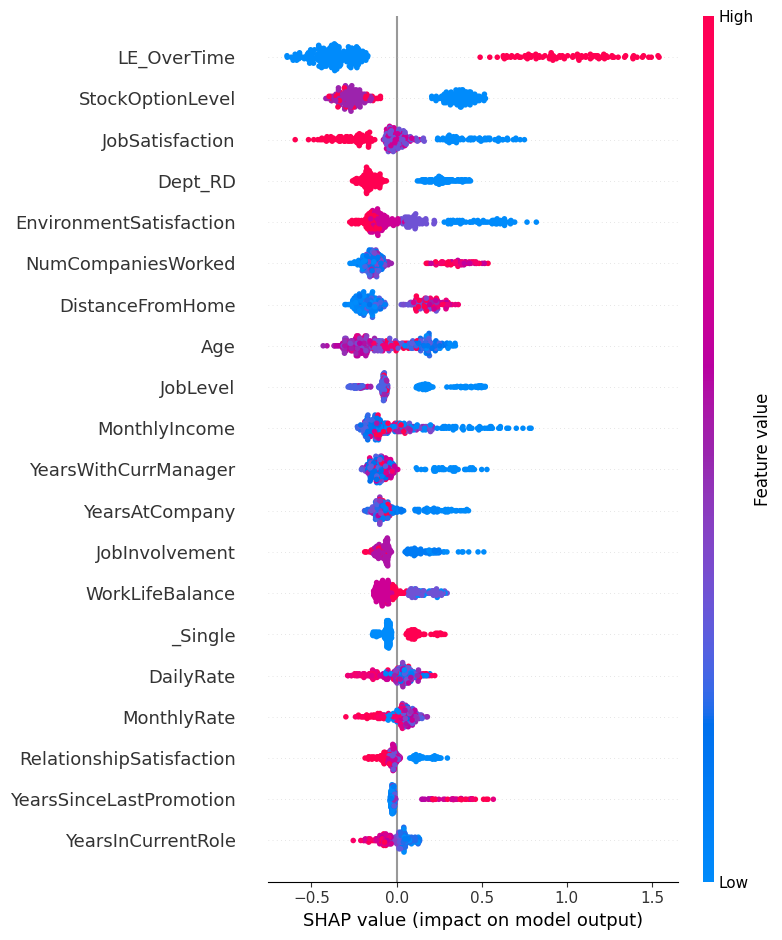

In [39]:
explainer = shap.Explainer(lgbm, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

#### XGBoost

In [40]:
xgb_space = {
    'max_depth': hp.quniform("max_depth", 3, 10, 1),  #Max depth 10
    'gamma': hp.loguniform('gamma', np.log(1), np.log(100)),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.loguniform('min_child_weight',np.log(1), np.log(100)),
    'n_estimators': hp.quniform('n_estimators', 50, 250, 1),
    #'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    #'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 50, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'random_state': 42,   
}
model = xgboost.XGBClassifier()
xgb_results = Models.optimize_model(xgb_space, model, X_train, y_train, 500, -1)

100%|██████████| 500/500 [05:20<00:00,  1.56trial/s, best loss: -0.33982177272618436]


In [41]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(xgb_results)

,params,loss,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
265,"{'colsample_bytree': 0.6663822963847371, 'gamma': 1.0757693848247785, 'learning_rate': 0.057722355360806867, 'max_depth': 10, 'min_child_weight': 2.1044134965173598, 'n_estimators': 132, 'random_state': 42, 'reg_alpha': 2.5092465896841953, 'reg_lambda': 1.4715973775849878, 'subsample': 0.7756253304389867}",-0.339822,0.847129,0.520833,0.652458,0.578495,0.620456,0.808482,0.584969
66,"{'colsample_bytree': 0.7387861647649503, 'gamma': 1.2601071057977267, 'learning_rate': 0.02136099667612161, 'max_depth': 8, 'min_child_weight': 1.235645245643873, 'n_estimators': 142, 'random_state': 42, 'reg_alpha': 3.3726690061363627, 'reg_lambda': 0.03757437493962845, 'subsample': 0.8805355038095242}",-0.330454,0.843757,0.512500,0.644789,0.569509,0.611842,0.809832,0.564751
136,"{'colsample_bytree': 0.6100926428441213, 'gamma': 3.4197585487431654, 'learning_rate': 0.08149174885304876, 'max_depth': 8, 'min_child_weight': 10.489774789553392, 'n_estimators': 114, 'random_state': 42, 'reg_alpha': 0.9779817579521057, 'reg_lambda': 0.9670929586577064, 'subsample': 0.9107678700103793}",-0.329516,0.843746,0.512500,0.642958,0.570069,0.611578,0.812195,0.567591
395,"{'colsample_bytree': 0.5342818276771897, 'gamma': 1.0996691332119033, 'learning_rate': 0.1467570640805792, 'max_depth': 10, 'min_child_weight': 5.470362093294223, 'n_estimators': 84, 'random_state': 42, 'reg_alpha': 4.517923722406332, 'reg_lambda': 1.8814955844646128, 'subsample': 0.8211588813556976}",-0.329277,0.842895,0.510034,0.645599,0.564868,0.608895,0.807813,0.571390
392,"{'colsample_bytree': 0.5687434923088414, 'gamma': 2.9838363798323813, 'learning_rate': 0.09762383664598442, 'max_depth': 10, 'min_child_weight': 5.515986095866035, 'n_estimators': 110, 'random_state': 42, 'reg_alpha': 2.6424982851834424, 'reg_lambda': 1.9074488965929501, 'subsample': 0.8262860549164008}",-0.328496,0.843750,0.512500,0.640967,0.569209,0.610073,0.805120,0.571832
...,...,...,...,...,...,...,...,...,...
62,"{'colsample_bytree': 0.6847020331270204, 'gamma': 41.43338690407689, 'learning_rate': 0.04160620425720991, 'max_depth': 7, 'min_child_weight': 20.01682979905707, 'n_estimators': 192, 'random_state': 42, 'reg_alpha': 6.0795196796539726, 'reg_lambda': 3.7400181983095218, 'subsample': 0.5413330347001847}",-0.000000,0.161314,0.161314,1.000000,0.277683,0.489785,0.500000,0.161314
35,"{'colsample_bytree': 0.6526013113443332, 'gamma': 10.06305042203157, 'learning_rate': 0.01317735194323486, 'max_depth': 8, 'min_child_weight': 85.18195349761056, 'n_estimators': 148, 'random_state': 42, 'reg_alpha': 3.470789516225546, 'reg_lambda': 2.818502789366803, 'subsample': 0.8596034849409945}",-0.000000,0.161299,0.161299,1.000000,0.276276,0.484851,0.500000,0.161299
1,"{'colsample_bytree': 0.5416674063248743, 'gamma': 4.344097792575635, 'learning_rate': 0.10214068315075826, 'max_depth': 9, 'min_child_weight': 41.1423829696104, 'n_estimators': 84, 'random_state': 42, 'reg_alpha': 8.32096574183215, 'reg_lambda': 1.5830114512867177, 'subsample': 0.5195995209760742}",-0.000000,0.161339,0.161339,1.000000,0.277388,0.488638,0.500000,0.161339
0,"{'colsample_bytree': 0.8119619590379261, 'gamma': 14.873449660641803, 'learning_rate': 0.07503360479522948, 'max_depth': 6, 'min_child_weight': 75.11286442262589, 'n_estimators': 113, 'random_state': 42, 'reg_alpha': 8.638697947452807, 'reg_lambda': 2.792860391316365, 'subsample': 0.7100180826693587}",-0.000000,0.161353,0.161353,1.000000,0.277150,0.487833,0.500000,0.161353


In [42]:
xgb = xgboost.XGBClassifier(**xgb_results.iloc[0]['params']).fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_test)[:,1]
xgb_test = Models.classification_metrics(y_test, xgb_proba)
xgb_test

{'accuracy': 0.847972972972973,
 'precision': 0.5166666666666667,
 'recall': 0.6595744680851063,
 'f1': 0.5794392523364487,
 'f2': 0.625,
 'roc_auc': 0.839271981543194,
 'pr_auc': 0.6176507260806898}

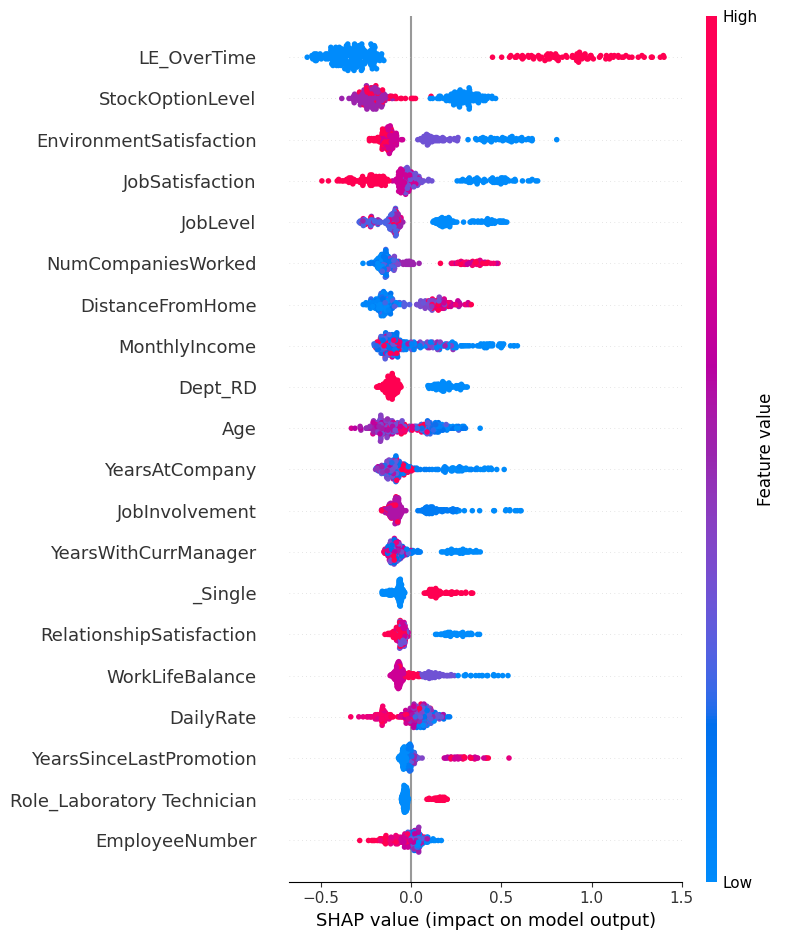

In [43]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)